In [10]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import torch
from torch import Tensor
from rich import print
import torch
from time import perf_counter
from typing import List, Tuple, Union, Callable
import numpy as np
from icecream import ic

from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import openai
import os


# now plot the embeddings
import matplotlib.pyplot as plt
import mplcursors

%matplotlib ipympl

from utils import plot_2D
from dotenv import load_dotenv
load_dotenv()

from tenacity import retry, stop_after_attempt, wait_random_exponential


import google.generativeai as genai
import google.ai.generativelanguage as glm
from google.api_core import retry as gretry

from tqdm.auto import tqdm

In [3]:
openai.api_key = os.getenv('OPENAI_API_KEY')
API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=API_KEY)
# OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')


In [4]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001

In [5]:
# define model
model_name = "bert-base-uncased"

# define the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

In [6]:
# test data for the exploration
in_1 = "Missing flamingo discovered at swimming pool"

in_2 = "Sea otter spotted on surfboard by beach"

in_3 = "Baby panda enjoys boat ride"

in_4 = "Breakfast themed food truck beloved by all!"

in_5 = "New curry restaurant aims to please!"

in_6 = "Python developers are wonderful people"

in_7 = "TypeScript, C++ or Java? All are great!"
input_text_lst_news = [in_1, in_2, in_3, in_4, in_5, in_6, in_7]

## Sentence Embedding with Bert

In [7]:
def bert_sentence_embed(input_sentence: str, model: BertModel = bert_model, word_ave: bool = True) -> Tensor:
    """A function to generate sentence embedding using Bert

    Args:
        input_sentence (str): The sentence to embed

    Returns:
        Tensor: Tensor output for the sentence embedding
    """

    temp_list = []
    for text in input_sentence:
        input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')
        # input_ids = tokenizer.encode(input_text_lst_news[0], return_tensors='pt')
        with torch.no_grad():
            outputs = model(input_ids)

            if word_ave:
                sentence_embedding = outputs.last_hidden_state.mean(dim=1)
            else:
                sentence_embedding = outputs.last_hidden_state
                sentence_embedding = sentence_embedding[0, 0, :].reshape(1, -1)
            temp_list.append(sentence_embedding)
    concatenated_sent_tensor = torch.cat(temp_list)
    # # Convert the concatenated tensor to a numpy array
    sent_numpy_array = concatenated_sent_tensor.numpy()

    # # Reshape the numpy array into a 1 by 768 array
    sent_numpy_array = sent_numpy_array.reshape(len(temp_list), temp_list[0].shape[1])
    return sent_numpy_array

In [8]:
def create_sentence_embedding(input_text: List[str],model:Union[Callable, object], 
bert: bool = True, word_ave: bool = True) -> np.array:
    """A function to create sentence embedding from a list of text using 
        Bert or other open source model
    Args:
        input_text (List): List of sentence to create embedding for

    Returns:
        np.array: np.array for all of the the sentence embedding
    """
    embed_list = []
    # model_name = 'bert-base-uncased'
    if bert:
        sent_numpy_array = bert_sentence_embed(input_text_lst_news, model, word_ave)
        
    else:
        for text in input_text_lst_news:
            sen_emb = model.encode(text)
            embed_list.append(sen_emb)
        concatenated_sent_tensor = np.concatenate(embed_list)

        # Reshape the numpy array into a 1 by 768 array
        sent_numpy_array = concatenated_sent_tensor.reshape(len(embed_list), len(embed_list[0]))

    # Perform PCA for 2D visualization
    # convert the 768-dimensional array to 2-dimentional array for plotting purpose
    PCA_model = PCA(n_components=2)
    PCA_model.fit(sent_numpy_array)
    sent_low_dim_array = PCA_model.transform(sent_numpy_array)

    return sent_numpy_array, sent_low_dim_array

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")
# model = SentenceTransformer('all-MiniLM-L6-v2')
_, low_dim= create_sentence_embedding(input_text_lst_news, model, bert = False)
plot_2D(low_dim[:,0], low_dim[:,1], input_text_lst_news)

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")
# model = SentenceTransformer('all-MiniLM-L6-v2')
_, low_dim= create_sentence_embedding(input_text_lst_news, model, bert = False)
plot_2D(low_dim[:,0], low_dim[:,1], input_text_lst_news)

## Openai Sentence embedding

In [11]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, model="text-similarity-davinci-001", **kwargs) -> List[float]:

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = openai.embeddings.create(input=[text], model=model, **kwargs)

    return response.data[0].embedding


@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embeddings(
    list_of_text: List[str], model="text-similarity-babbage-001", **kwargs
) -> List[List[float]]:
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."

    # replace newlines, which can negatively affect performance.
    list_of_text = [text.replace("\n", " ") for text in list_of_text]

    data = openai.embeddings.create(input=list_of_text, model=model, **kwargs).data
    embed_list = [d.embedding for d in data]
    embed_array = np.array(embed_list)

    # Convert to 2-dimensional vector to be able to visualize the embeddings
    PCA_model = PCA(n_components=2)
    PCA_model.fit(embed_array)
    sent_low_dim_array = PCA_model.transform(embed_array)
    return embed_array, sent_low_dim_array

    # embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191



In [47]:
# openai.api_key = os.getenv("OPENAI_API_KEY")
_, low_dim_response = get_embeddings(input_text_lst_news)

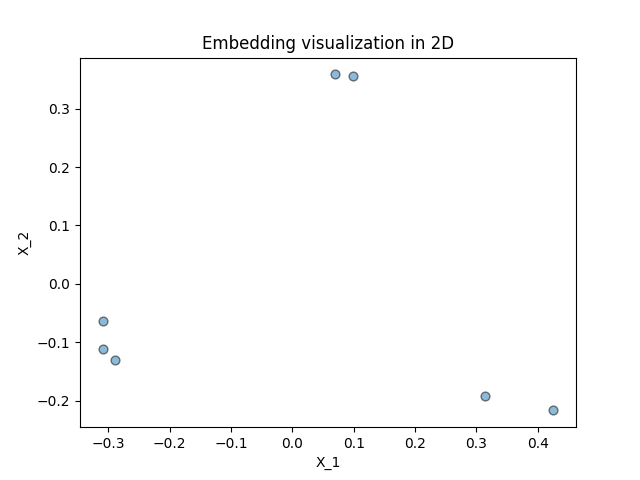

In [48]:
plot_2D(low_dim_response[:,0], low_dim_response[:,1], input_text_lst_news)

## Sentence Embedding with Gemini

In [6]:
# list the embedding model from Gemini
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001

In [30]:
gmodel = "models/embedding-001"
def gembed_fn(model, input_text: List[str]) -> np.array:
    embed_list = []
    for text in input_text:
        # set the task type to semantic_similarity
        embedding = genai.embed_content(model = model, content = text, 
        task_type = "semantic_similarity")["embedding"]
        embed_list.append(embedding)
    embed_array = np.array(embed_list)
     # Convert to 2-dimensional vector to be able to visualize the embeddings
    PCA_model = PCA(n_components=2)
    PCA_model.fit(embed_array)
    sent_low_dim_array = PCA_model.transform(embed_array)
    return embed_array, sent_low_dim_array

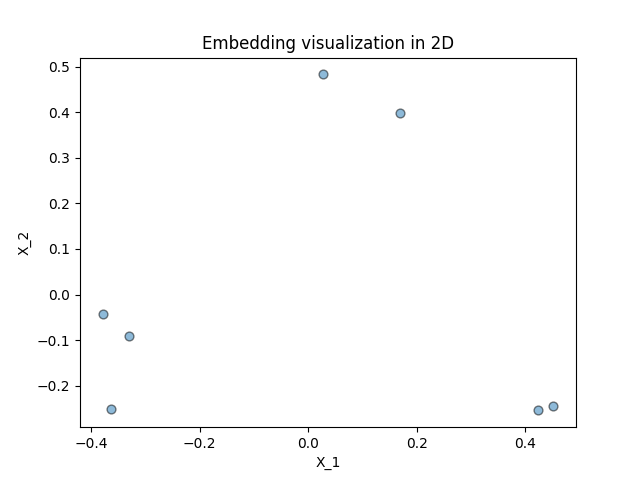

In [33]:
_, glow_dim_response = gembed_fn(gmodel, input_text_lst_news)
plot_2D(glow_dim_response[:,0], glow_dim_response[:,1], input_text_lst_news)